In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.stats import pearsonr

from zp_ihlt_project.config import TRAIN_DATA_WITH_FEATURES_PATH, TEST_DATA_WITH_FEATURES_PATH, FEATURE_STEPS_PATH, FEATURE_STEPS_WITH_IMPORTANCE_PATH
from zp_ihlt_project.feature_extraction import lexical_functions, preprocessing_functions, semantic_functions, ngram_functions, sentence_to_doc


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Train and Evaluate Models

This notebook demonstrates random forest regression models trained on various sets of features which were extracted in [extract_features.ipynb](extract_features.ipynb).


### Load feature data

We load the features that were extracted in [extract_features.ipynb](extract_features.ipynb), for both the training and test datasets. The test dataset is only used for final evaluation, and never for training. Validation is performed using cross-validation, as well as a train/val split.

In [2]:
all_train_df = pd.read_csv(TRAIN_DATA_WITH_FEATURES_PATH)
all_test_df = pd.read_csv(TEST_DATA_WITH_FEATURES_PATH)
feature_steps = pd.read_csv(FEATURE_STEPS_PATH)
feature_names = [col for col in all_train_df.columns if col.startswith("score_")]

## Baseline Model

We start by training a model on all features, using 5-fold cross-validation. We use a custom scorer function to calculate Pearson correlation with the gold standard scores.


In [3]:
results = []

def pearsonr_score(estimator, X, y):
    y_pred = estimator.predict(X)
    return pearsonr(y, y_pred)[0]

model = RandomForestRegressor()

scores = cross_val_score(
    model, 
    all_train_df[feature_names],
    all_train_df.gs,
    cv=5,
    n_jobs=-1,
    scoring=pearsonr_score
)
print(f"Cross-validation Pearson: {np.mean(scores)}+-{np.std(scores)}")


Cross-validation Pearson: 0.7360983685338869+-0.10241627382691505


We see that the model achieves a Pearson correlation of ~0.730, with a rather large standard deviation of ~0.10.

In [4]:
train_idx, val_idx = train_test_split(range(len(all_train_df)), test_size=0.2, random_state=42)

In [5]:
model = RandomForestRegressor()
model.fit(all_train_df.iloc[train_idx][feature_names], all_train_df.iloc[train_idx].gs)


RandomForestRegressor()

### Datasets
Sometimes we will evaluate the model on all datasets, but sometimes we will evaluate on a single corpus at a time.

In [6]:
train_datasets = all_train_df.dataset.unique().tolist()
test_datasets = all_test_df.dataset.unique().tolist()

### Evaluation Helper

We will be training models which vary by the features used, we will need to split data by dataset, and we will need to evaluate them across train/val/test. We define a helper function to get the `X` and `y` data given these parameters.

Our evaluation helper function also calculates Pearson correlation with the gold standard scores. We can see the scores for each split and each dataset, as well as the overall scores.

In [7]:
def get_X_y(df, selected_features, dataset, idx=None):
    if idx is None:
        idx = range(len(df))
    X = df.iloc[idx]
    X = X.loc[X.dataset == dataset][selected_features]
    y = df.iloc[idx]
    y = y.loc[y.dataset == dataset].gs
    return X, y

def evaluate_model_across_train_val_test(model, selected_features):
    results = []
    datasets = train_datasets
    for dataset in datasets:
        dataset_results = []
        dataset_results.append(dataset)
        
        X_train, y_train = get_X_y(all_train_df, selected_features, dataset, train_idx)
        X_val, y_val = get_X_y(all_train_df, selected_features, dataset, val_idx)
        X_test, y_test = get_X_y(all_test_df, selected_features, dataset)

        preds = model.predict(X_train)
        dataset_results.append(pearsonr(y_train, preds)[0])

        preds = model.predict(X_val)
        dataset_results.append(pearsonr(y_val, preds)[0])

        preds = model.predict(X_test)
        dataset_results.append(pearsonr(y_test, preds)[0])

        results.append(dataset_results)

    dataset_results = []
    dataset_results.append('all')
    preds = model.predict(all_train_df.iloc[train_idx][selected_features])
    dataset_results.append(pearsonr(all_train_df.iloc[train_idx].gs, preds)[0])

    preds = model.predict(all_train_df.iloc[val_idx][selected_features])
    dataset_results.append(pearsonr(all_train_df.iloc[val_idx].gs, preds)[0])

    preds = model.predict(all_test_df[all_test_df.dataset.isin(train_datasets)][selected_features])
    dataset_results.append(pearsonr(all_test_df[all_test_df.dataset.isin(train_datasets)].gs, preds)[0])

    results.append(dataset_results)

    results = pd.DataFrame(results, columns=["dataset", "train_pearson", "val_pearson", "test_pearson"])
    return results

evaluate_model_across_train_val_test(model, feature_names)

,dataset,train_pearson,val_pearson,test_pearson
0,MSRpar,0.974178,0.643522,0.644125
1,MSRvid,0.981876,0.767773,0.837101
2,SMTeuroparl,0.965780,0.787358,0.507018
3,all,0.984985,0.842976,0.806098


With no feature selection, we see that the model achieves a Pearson correlation of ~0.984 on the training set, ~0.840 on the validation set, and ~0.808 on the test set.

## Analyze Feature Importances

\>2000 features is a lot of features! It requires ~1min to train, and it may not be clear which features the model is paying attention to. A random forest regressor allows us to extract the feature importances directly and inspect the values. We can then try training and evaluating new models on a subset of features.

In [8]:
feature_importances = model.feature_importances_
ranked_feature_importance_indices = np.argsort(feature_importances)[::-1]
feature_steps['importance'] = feature_importances
feature_steps.sort_values(by='importance', ascending=False, inplace=True)
feature_steps.to_csv(FEATURE_STEPS_WITH_IMPORTANCE_PATH)
feature_steps.head(10)

,name,metric,step_0,step_1,step_2,step_3,step_4,step_5,step_6,step_7,importance
660,score_jaccard_165,jaccard,sentence_to_doc,get_tokens,remove_stopwords,lemmatize_tokens,get_characters,get_2grams,NaN,NaN,0.197279
1029,score_cosine_257,cosine,sentence_to_doc,chunk_NEs,remove_stopwords,lemmatize_tokens,get_characters,get_2grams,NaN,NaN,0.088892
661,score_cosine_165,cosine,sentence_to_doc,get_tokens,remove_stopwords,lemmatize_tokens,get_characters,get_2grams,NaN,NaN,0.069110
1032,score_jaccard_258,jaccard,sentence_to_doc,chunk_NEs,remove_stopwords,lemmatize_tokens,get_characters,get_3grams,NaN,NaN,0.033215
1033,score_cosine_258,cosine,sentence_to_doc,chunk_NEs,remove_stopwords,lemmatize_tokens,get_characters,get_3grams,NaN,NaN,0.021891
1024,score_jaccard_256,jaccard,sentence_to_doc,chunk_NEs,remove_stopwords,lemmatize_tokens,get_characters,NaN,NaN,NaN,0.021170
1028,score_jaccard_257,jaccard,sentence_to_doc,chunk_NEs,remove_stopwords,lemmatize_tokens,get_characters,get_2grams,NaN,NaN,0.020992
665,score_cosine_166,cosine,sentence_to_doc,get_tokens,remove_stopwords,lemmatize_tokens,get_characters,get_3grams,NaN,NaN,0.020653
388,score_jaccard_97,jaccard,sentence_to_doc,chunk_NEs,lemmatize_tokens,get_characters,get_2grams,NaN,NaN,NaN,0.019479
164,score_jaccard_41,jaccard,sentence_to_doc,get_tokens,lemmatize_tokens,get_characters,get_2grams,NaN,NaN,NaN,0.018991


In [9]:
print(f"Sum of top 10 feature importances: {sum(feature_steps.head(10).importance)}")
print(f"Sum of all feature importances: {sum(feature_steps.importance)}")
print(f"Number of features: {len(feature_steps)}")

Sum of top 10 feature importances: 0.5116713407512495
Sum of all feature importances: 1.0
Number of features: 2080


We see that the top 10 features account for ~50% of the total feature importances.

### Train Models on features with non-zero importances
We can try training models on a subset of the features with non-zero importances.

In [10]:
nonzero_feature_importances = feature_importances > 0
nonzero_importance_feature_indexes = ranked_feature_importance_indices[nonzero_feature_importances]
nonzero_importance_features = np.array(feature_names)[nonzero_importance_feature_indexes]
print(f"Number of features with non-zero importances: {len(nonzero_importance_features)}")
nonzero_importance_features_model = RandomForestRegressor()
nonzero_importance_features_model.fit(all_train_df.iloc[train_idx][nonzero_importance_features], all_train_df.iloc[train_idx].gs)

Number of features with non-zero importances: 1248


RandomForestRegressor()

It turns out there are 1248 features with non-zero importances, which is about 60% of the total number of features.

In [11]:
evaluate_model_across_train_val_test(nonzero_importance_features_model, nonzero_importance_features)

,dataset,train_pearson,val_pearson,test_pearson
0,MSRpar,0.972210,0.637189,0.648284
1,MSRvid,0.981950,0.761280,0.840884
2,SMTeuroparl,0.966041,0.781254,0.504121
3,all,0.984789,0.838806,0.810086


As expected, the difference in performance is negligible.

### Train Models on top 500 features
We can also try training models on the top 500 features.

In [12]:
top_500_features_indices = ranked_feature_importance_indices[:500]
top_500_features = np.array(feature_names)[top_500_features_indices]

In [13]:
top_500_features_model = RandomForestRegressor()
top_500_features_model.fit(all_train_df.iloc[train_idx][top_500_features], all_train_df.iloc[train_idx].gs)

RandomForestRegressor()

In [14]:
evaluate_model_across_train_val_test(top_500_features_model, top_500_features)

,dataset,train_pearson,val_pearson,test_pearson
0,MSRpar,0.973630,0.650552,0.641161
1,MSRvid,0.981530,0.758242,0.841195
2,SMTeuroparl,0.962845,0.794003,0.494745
3,all,0.984535,0.841279,0.808478


With only 500 features, we see a slight drop in performance, but the model takes about half the time to train.

## Evaluating Feature Groups

The methods used to extract features include lexical, semantic, and n-gram methods, along with some preprocessing steps. We can try training models on subsets of these feature groups to see if one is more important than the others.

We define a helper function to filter features by the steps used to extract them. We can specify the feature groups simply using the list of processing functions that are defined in [feature_extraction.py](../src/zp_ihlt_project/feature_extraction.py).

In [15]:
def filter_features_by_steps(
    feature_steps,
    allowed_steps,
):
    allowed_step_names = [step.__name__ for step in [sentence_to_doc, *allowed_steps]]
    step_col_names = [col for col in feature_steps.columns if col.startswith("step_")]
        
    selected_features = []
    for _, row in feature_steps.iterrows():
        if all(pd.isna(step) or step in allowed_step_names for step in row[step_col_names]):
            feature_name = row["name"]
            selected_features.append(feature_name)
    return selected_features


### Lexical Features (Without Semantic Features)

In [16]:
lexical_features = filter_features_by_steps(feature_steps, preprocessing_functions + lexical_functions + ngram_functions)
print(f"Number of lexical-based features: {len(lexical_features)}")

Number of lexical-based features: 320


In [17]:
lexical_model = RandomForestRegressor()
lexical_model.fit(all_train_df.iloc[train_idx][lexical_features], all_train_df.iloc[train_idx].gs)
evaluate_model_across_train_val_test(lexical_model, lexical_features)

,dataset,train_pearson,val_pearson,test_pearson
0,MSRpar,0.971768,0.639186,0.635244
1,MSRvid,0.980093,0.721861,0.814018
2,SMTeuroparl,0.959683,0.762564,0.509796
3,all,0.983574,0.822466,0.802020


Training using only Lexical Features and N-grams has a very slight detrimental effect on performance, but the model is still very strong. This suggests that the lexical features are an important component of the model, but not the only important component.

### Semantic Features (Without Lexical Features)

In [18]:
semantic_features = filter_features_by_steps(feature_steps, preprocessing_functions + semantic_functions + ngram_functions)
print(f"Number of semantic-based features: {len(semantic_features)}")

Number of semantic-based features: 240


In [19]:
semantic_model = RandomForestRegressor()
semantic_model.fit(all_train_df.iloc[train_idx][semantic_features], all_train_df.iloc[train_idx].gs)
evaluate_model_across_train_val_test(semantic_model, semantic_features)

,dataset,train_pearson,val_pearson,test_pearson
0,MSRpar,0.964268,0.538772,0.539214
1,MSRvid,0.967514,0.755855,0.809662
2,SMTeuroparl,0.961793,0.834445,0.435886
3,all,0.977488,0.832087,0.771758


If we use only semantic features and N-grams, there is a fairly large drop in performance on the test set, although the validation set performance actually improves. This suggests that semantic features may not be very good generalizable features for this task.

### Without N-grams

We were also curious to see if n-grams were important, so we trained a model without them.

In [20]:
without_ngrams_features = filter_features_by_steps(feature_steps, preprocessing_functions + semantic_functions + lexical_functions)
print(f"Number of n-gram-based features: {len(without_ngrams_features)}")

Number of n-gram-based features: 520


In [21]:
without_ngrams_model = RandomForestRegressor()
without_ngrams_model.fit(all_train_df.iloc[train_idx][without_ngrams_features], all_train_df.iloc[train_idx].gs)
evaluate_model_across_train_val_test(without_ngrams_model, without_ngrams_features)

,dataset,train_pearson,val_pearson,test_pearson
0,MSRpar,0.968983,0.635744,0.574888
1,MSRvid,0.979741,0.729104,0.805588
2,SMTeuroparl,0.961235,0.751814,0.473486
3,all,0.983097,0.821402,0.770824


Here, we see that while validation performance is largely the same, test performance is worse. This suggests that n-grams are a key feature that generalizes well to the test set.

## Model Comparison on Test Set

Now we train models using all training data, in hope of achieving the best possible performance on the full test set, including unseen datasets. We will train on all available training data, and evaluate on all test data, for each of the feature subsets above.

In [120]:
def evaluate_model_across_test(model, selected_features):
    results = []
    datasets = test_datasets
    for dataset in datasets:
        preds = model.predict(all_test_df[all_test_df.dataset == dataset][selected_features])
        results.append(pearsonr(all_test_df[all_test_df.dataset == dataset].gs, preds)[0])

    preds = model.predict(all_test_df[selected_features])
    results.append(pearsonr(all_test_df.gs, preds)[0])
    results = pd.DataFrame(results, columns=["test_pearson"], index=datasets + ['all'])
    return results

fully_trained_model = RandomForestRegressor()
fully_trained_model.fit(all_train_df[feature_names], all_train_df.gs)
fully_trained_test_results = evaluate_model_across_test(fully_trained_model, feature_names)

fully_trained_without_semantic_model = RandomForestRegressor()
fully_trained_without_semantic_model.fit(all_train_df[lexical_features], all_train_df.gs)
fully_trained_without_semantic_test_results = evaluate_model_across_test(fully_trained_without_semantic_model, lexical_features)

fully_trained_without_lexical_model = RandomForestRegressor()
fully_trained_without_lexical_model.fit(all_train_df[semantic_features], all_train_df.gs)
fully_trained_without_lexical_test_results = evaluate_model_across_test(fully_trained_without_lexical_model, semantic_features)

fully_trained_without_ngrams_model = RandomForestRegressor()
fully_trained_without_ngrams_model.fit(all_train_df[without_ngrams_features], all_train_df.gs)
fully_trained_without_ngrams_test_results = evaluate_model_across_test(fully_trained_without_ngrams_model, without_ngrams_features)


## Results Summary

In [123]:
test_results_all = pd.concat([
    fully_trained_without_semantic_test_results, 
    fully_trained_without_lexical_test_results, 
    fully_trained_without_ngrams_test_results, 
    fully_trained_test_results
], axis=1)
test_results_all.columns = ['without_semantic', 'without_lexical', 'without_ngrams', 'all']
test_results_all

,without_semantic,without_lexical,without_ngrams,all
MSRpar,0.646301,0.533445,0.576701,0.643341
MSRvid,0.813124,0.811112,0.806899,0.838727
SMTeuroparl,0.520886,0.437063,0.475293,0.494997
OnWN,0.670711,0.470130,0.623205,0.647480
SMTnews,0.451486,0.367224,0.438376,0.419613
all,0.717880,0.638843,0.686215,0.733604


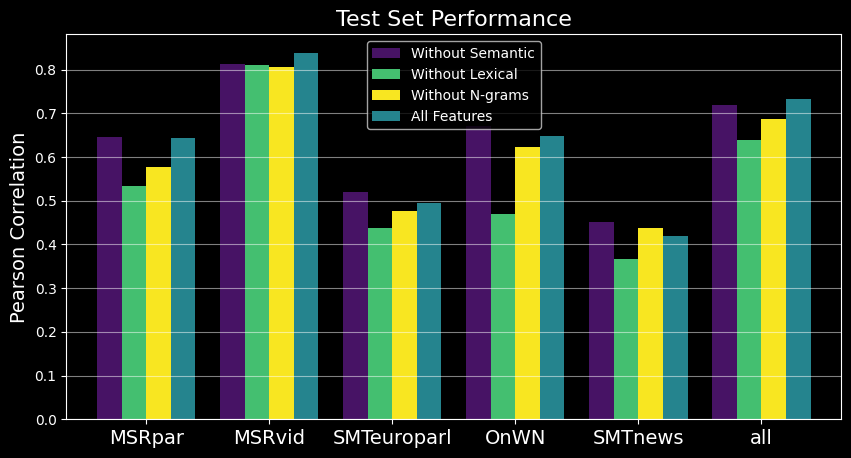

In [124]:
cmap = plt.get_cmap('viridis')
lexical_color = cmap(0.05)
semantic_color = cmap(0.7)
without_ngrams_color = cmap(0.99)
all_color = cmap(0.45)


fig, ax = plt.subplots(figsize=(10, 5))
test_results_all.plot(kind='bar', ax=ax, color=[lexical_color, semantic_color, without_ngrams_color, all_color], width=0.8)
ax.set_ylabel("Pearson Correlation", size=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size=14)
ax.set_title("Test Set Performance", size=16)
ax.legend(['Without Semantic', 'Without Lexical', 'Without N-grams', 'All Features'])
ax.grid(axis='y', alpha=0.5)

plt.show()

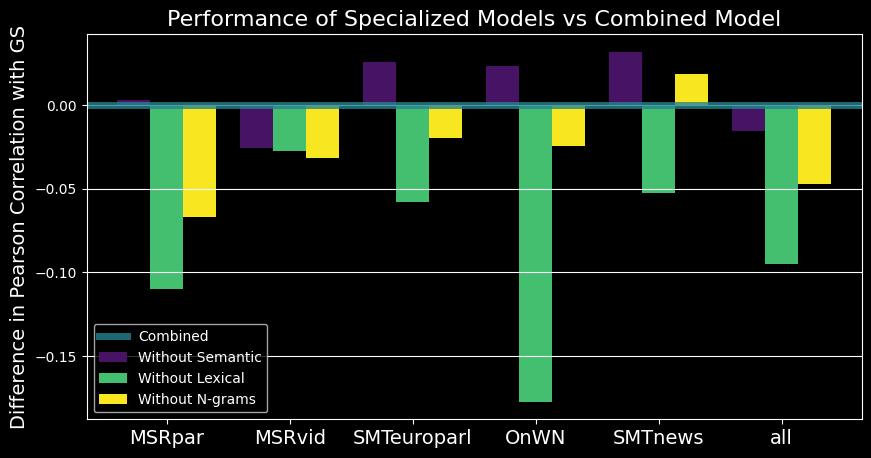

In [125]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 5))

differences = pd.DataFrame({
    'without_semantic_vs_all': test_results_all['without_semantic'] - test_results_all['all'],
    'without_lexical_vs_all': test_results_all['without_lexical'] - test_results_all['all'],
    'without_ngrams_vs_all': test_results_all['without_ngrams'] - test_results_all['all']
})

differences.plot(kind='bar', ax=ax, color=[lexical_color, semantic_color, without_ngrams_color], width=0.8)
ax.axhline(y=0, color=all_color, linestyle='-', alpha=0.8, linewidth=5)

ax.set_ylabel("Difference in Pearson Correlation with GS", size=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, size=14)
ax.set_title("Performance of Specialized Models vs Combined Model", size=16)
ax.legend(['Combined', 'Without Semantic', 'Without Lexical', 'Without N-grams'])
ax.grid(axis='y')

plt.show()

# Discussion

## Introduction
This study explored the effectiveness of different feature types in predicting semantic text similarity using Random Forest regression models. We examined lexical features, semantic features, and n-grams, both independently and in combination, to understand their relative contributions to model performance.

## Approach
We adopted an unbiased, data-driven approach to feature selection for semantic text similarity prediction. Rather than making assumptions about which features would be most effective, we:

1. Generated a comprehensive set of ~2000 potential features, including:
   - Lexical features (e.g., characters, word pairs)
   - Semantic features (e.g., lemmatization, word sense disambiguation)
   - N-gram features at various levels
   
2. Leveraged Random Forest's inherent feature importance capabilities to:
   - Let the model naturally identify the most predictive features
   - Quantify the contribution of each feature to the final predictions
   - Avoid manual feature engineering bias

3. Systematically analyzed feature importance by:
   - Examining the top contributors
   - Testing reduced feature sets
   - Evaluating feature groups (lexical vs semantic vs n-grams)

This approach allowed us to start with a broad feature space and let the data guide us toward the most effective feature combinations, rather than relying on preconceptions about which features would be most valuable for semantic similarity tasks.


## Methods
### Feature Extraction
Inspired by previous labwork in which we noticed that varying the order of feature extraction steps could result in different feature combinations and therefore different similarity scores, we hypothesized that the best features may be a combination of many different steps.

The feature extraction tools, defined in [feature_extraction.py](../src/zp_ihlt_project/feature_extraction.py), are used in [extract_features.ipynb](extract_features.ipynb) to extract features using every valid permutation of the processing steps and 4 similarity metrics. This naive approach makes no assumptions about which steps or particular features are most important.

To speed up the feature extraction process, we convert token lists to tuples and use caching to store intermediate results, knowing that many steps will result in the same output, even when the order of the steps is different. This significantly saves computation time while preserving the readability of the pipeline, and allows the extraction process for ~2000 features across ~1500 sentences to be computed in ~15 minutes. We then store the results in a CSV file for future use.

### Model Training
Our approach involved training several Random Forest models using different feature subsets:
- A baseline model using all ~2000 features
- Models using feature importance-based selection (top 500 features)
- Models using only lexical features
- Models using only semantic features
- Models without n-gram features

### Model Evaluation
We evaluated performance using Pearson correlation across multiple datasets (MSRpar, MSRvid, SMTeuroparl, OnWN, and SMTnews) and different data splits (train/validation/test).

## Results
Key findings from our analysis include:

1. **Feature Importance**
   - The top 10 features accounted for approximately 50% of the total feature importance
   - About 60% of features (1,248) had non-zero importance
   - Reducing to 500 features maintained similar performance while improving training efficiency

2. **Feature Type Comparison**
   - Combined features performed best overall (r = 0.734 on test)
   - Lexical features alone achieved strong performance (r = 0.718 on test)
      - Interestingly, for some datasets, using only lexical features performed better than using all features
   - Semantic features alone showed lower generalization (r = 0.640 on test)
   - N-grams proved important for generalization to unseen data. Removing n-grams resulted in a drop in performance on the test set (r = 0.686 on test)

3. **Dataset-Specific Performance**
   - MSRvid showed consistently highest performance across all models (r > 0.80)
   - SMTnews and SMTeuroparl showed lower performance (r < 0.52)
   - Performance varied significantly across datasets, suggesting domain-specific challenges

### Feature Importance Analysis

| Feature Name | Metric | Processing Steps | Importance |
|-------------|--------|------------------|------------|
| score_jaccard_165 | Jaccard | sentence_to_doc → get_tokens → remove_stopwords → lemmatize_tokens → get_characters → get_2grams | 0.197 |
| score_cosine_257 | Cosine | sentence_to_doc → chunk_NEs → remove_stopwords → lemmatize_tokens → get_characters → get_2grams | 0.089 |
| score_cosine_165 | Cosine | sentence_to_doc → get_tokens → remove_stopwords → lemmatize_tokens → get_characters → get_2grams | 0.069 |
| score_jaccard_258 | Jaccard | sentence_to_doc → chunk_NEs → remove_stopwords → lemmatize_tokens → get_characters → get_3grams | 0.033 |
| score_cosine_258 | Cosine | sentence_to_doc → chunk_NEs → remove_stopwords → lemmatize_tokens → get_characters → get_3grams | 0.022 |
| score_jaccard_256 | Jaccard | sentence_to_doc → chunk_NEs → remove_stopwords → lemmatize_tokens → get_characters | 0.021 |
| score_jaccard_257 | Jaccard | sentence_to_doc → chunk_NEs → remove_stopwords → lemmatize_tokens → get_characters → get_2grams | 0.021 |
| score_cosine_166 | Cosine | sentence_to_doc → get_tokens → remove_stopwords → lemmatize_tokens → get_characters → get_3grams | 0.021 |
| score_jaccard_97 | Jaccard | sentence_to_doc → chunk_NEs → lemmatize_tokens → get_characters → get_2grams | 0.019 |
| score_jaccard_41 | Jaccard | sentence_to_doc → get_tokens → lemmatize_tokens → get_characters → get_2grams | 0.019 |
| ... | ... | ... | ... |

Examining the top 10 features by importance reveals several clear patterns:

1. **Metric Types**
   - Jaccard similarity dominates (6 of top 10 features)
   - Cosine similarity complements (4 of top 10 features)
   - The highest-performing feature (Jaccard_165) accounts for nearly 20% of total importance

2. **Processing Pipeline Patterns**
   - All top features include `sentence_to_doc`, `lemmatize_tokens`, and `get_characters` steps
   - Most include `remove_stopwords` (8 of 10)
   - N-grams appear frequently (9 of 10), with 2-grams being most common

3. **Named Entity Handling**
   - Features split between basic tokenization (`get_tokens`) and named entity chunking (`chunk_NEs`)
   - Both approaches appear effective, suggesting complementary information

4. **Pipeline Length**
   - Most successful features use 5-6 processing steps
   - More complex isn't necessarily better - simpler pipelines still appear in top features

This analysis suggests that while we started with ~2000 features, the most predictive features share common characteristics: they combine basic text preprocessing (lemmatization, stopword removal) with character-level analysis and n-grams, measured primarily through Jaccard similarity.

While these are the most important features, they only account for ~50% of the total feature importance, and the results already begin to diminish when using the top 500 features. This suggests that there are many other features that are also important, and that the top features are only a subset of the most important features.

## Summary
Our analysis demonstrates that while a combination of all features provides the best overall performance, lexical and n-gram features alone can achieve comparable results in many cases. The poor performance of the model that excludes lexical features suggests that lexical features are the most important, especially when generalizing to unseen data. The superiority of using all features over using only lexical features suggests that robust semantic similarity models benefit from diverse feature types.